In [71]:
from __future__ import print_function
import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.activations import relu

from util import *
from keras.layers.convolutional import ZeroPadding2D
from keras import backend as K
from scipy import io as spio
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import ssl
import os
from numpy import argmax
from sklearn.cluster import KMeans
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
ssl._create_default_https_context = ssl._create_unverified_context

In [72]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May  4 16:55:52 2019
purpose: cut cpatcha into single 
@author: chien
"""
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'

def cut(img_gray):
    def cut(img,mode='l'):
        w=[]
        flag1=1
        flag2=0
        for i in range(len(img)):
            if flag1==1:
                if img[i].sum()!=0:
                    w.append(i)
                    flag1=0
                    flag2=1
            if flag2==1:
                if img[i].sum()==0:
                    if(i-w[0]<20):
                        continue  #避免切成碎片
                    w.append(i)
                    break
        if len(w)==1:
            w.append(len(img))

        if (mode=='w'):
            if w[1]-w[0]>25:
                mid = (w[1]+w[0])//2
                rimg = img[ mid-16 : mid+16 ]
                return rimg
        rimg = img[ w[0] : w[1] ]
        return rimg
    
    img_grayT = img_gray.T
    Nimg = cut(img_grayT,'w').T
    Fimg = cut(Nimg)
    Fimg  = cv2.copyMakeBorder(Fimg,5,5,5,5,cv2.BORDER_CONSTANT,value=0)
    resized = cv2.resize(Fimg, (48,48), interpolation=cv2.INTER_AREA)
    return resized



def k_means(img):
    cor = []
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j]>10:
                cor.append([i,j])#coordinate
    cor = np.array(cor)
    
    estimator=KMeans(n_clusters=4)
    estimator.fit_predict(cor)
    lable_pred=estimator.labels_
    #    lable_pred = k_means(cor , 4)
    order = {}
    center_list=[]
    
    overlapping_flag = False
    show_flag = False
    for k in range(4):
        cor1=[]
        for i in range(len(cor)):
            if lable_pred[i]==k:    
                cor1.append(cor[i])
        ###cor1 is a set of coordinate of one of the group
        cor1 = np.array(cor1)
        center = int(np.mean(cor1.T[1]))
        max_ = np.max(cor1.T[1])
        min_ = np.min(cor1.T[1])
        
        limit = ((max_- min_)//2) + 2
        ##### 2 or 3
        
        #train 的時候可以拿掉
        ##two center is too close
        for c in center_list:
            if(abs(center - c)<3):
                order.pop(c)
                center_list.remove(c)
                overlapping_flag = True
                break
        
        if(overlapping_flag):
            overlapping_center = (c + center)//2
            limit -=5 ##重疊的兩張圖邊界通常會較小
            ###5->3
            another_center = overlapping_center - limit
            center = overlapping_center + limit
            
            imgtest = img.copy()
            imgtest[:,another_center+limit:]=0
            imgtest[:,:another_center-limit]=0
            order[another_center] = imgtest 
            overlapping_flag =False
            show_flag = True
        
        center_list.append(center)
        imgtest = img.copy()
        imgtest[:,center+limit:]=0
        imgtest[:,:center-limit]=0
        order[center] = imgtest 
                
    
    ########################################################################
    #normalize
    numpy_list = []
    for t in range(4):
        single = order.pop(min(order))
#        kernel = np.ones((2,2,1) , np.uint8)
#        dilation=cv2.dilate(single , kernel , iterations=1)
#        save = cut28(dilation)
#        save = cut(dilation)
#        numpy_list.append(dilation)   
        save = cut(single)
        numpy_list.append(save)
    
#     if (show_flag):
#         plt.figure(0,figsize=(4,8))
#         for im in range(4):   
#             plt.subplot(1,4,im+1)
#             plt.imshow(numpy_list[im])
#         show_flag = False
#         plt.show()
#         plt.clf()
    
    return numpy_list


In [73]:
path = "train.mat" 
data = sio.loadmat(path)

x_test = data['x_train']
y_test = data['y_train']
###############################
eighty = int((x_test.shape[0]-1)*0.8)
x_test = data['x_train'][eighty:]
y_test = data['y_train'][eighty:]
###############################

input_size = x_test[0]

print("-----original-----")
print("x shape : ",x_test.shape)
print("y shape : ",y_test.shape)

codeTable = {0:'2',1:'3',2:'4',3:'5',4:'7',5:'9',
             6:'A',7:'C',8:'F',9:'H',10:'K',11:'M',12:'N',
             13:'P',14:'Q',15:'R',16:'T',17:'Y',18:'Z'}

x = []
y = []

size = x_test.shape[0]
for i in range(size):
    img = k_means(x_test[i])
    y_ = y_test[i]
    for j in range(4):
        x.append(img[j])
        y.append(y_[j])
x_test = np.array(x)
y_test = np.array(y)
y_test = np.expand_dims(y_test, axis=1)

print("-----after processing-----")
print("x shape : ",x_test.shape)
print("y shape : ",y_test.shape)

# sio.savemat('third_single.mat', {'x_train': x,'y_train': y})



num_classes = 19
epochs = 10

# input image dimensions
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols,1)

################################
# path = "third_single.mat"
# data = scio.loadmat(path)
# x = data['x_train']
# y = data['y_train']
# size = int((x.shape[0]-1)*0.8)#3736
# x = x[size:]
# y = y[size:]
# x_test = x.copy()
# y_test = y.copy()
################################
x = x_test.copy()
y = y_test.copy()

##x_test、y_test
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0] , img_rows , img_cols , 1 , order="A")
y_test = keras.utils.to_categorical(y_test, num_classes)



#------------------------------------------------
# ''' load last data'''
print('-----load dataset-----')
model = load_model('vgg_test4_with_third_data_1.h5')

## 评估模型
loss,accuracy = model.evaluate(x_test,y_test)
print('loss',loss)
print('accuracy\n',accuracy)
#################################################
print("-----predict-----")
y_ = model.predict(x_test)
print("-----success-----")


-----original-----
x shape :  (1169, 48, 170)
y shape :  (1169, 4)
-----after processing-----
x shape :  (4676, 48, 48)
y shape :  (4676, 1)
-----load dataset-----
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
4676/4676 [==============================] - 6s 1ms/step
\loss 0.09954310071988254
accuracy
 0.9886655260906758
-----predict-----
-----success-----


In [76]:
num = x.shape[0]//4
assert x.shape[0]/4 == x.shape[0]//4
# num = input_size

four_pic_wrong_num = 0
sigle_wrong_num = 0
for i in range(num):
    ans_list = []
    predict_list= []
    wrong_word = 0
    for j in range(4):  
#         plt.figure(i,figsize=(3,4))
#         plt.subplot(1,4,j+1)
        cur_count = i*4+j
#         plt.imshow(x[cur_count])
        ans = codeTable[int(y[cur_count])]
#         plt.title(ans)
        ans_list.append(ans)
#         x_ = np.expand_dims(x[0], axis=0)
#         x_ = x_.reshape( -1 , img_rows , img_cols , 1 )
#         predict = codeTable[np.argmax(model.predict(x_))]
        predict = codeTable[np.argmax(y_[cur_count])]
        predict_list.append(predict)
        if (predict != ans):
#             plt.figure(cur_count , figsize = (1,1))
#             plt.imshow(x[cur_count])
#             plt.show()
#             print("answer = ",ans , "predict = ",predict)
#             print(cur_count)
            wrong_word+=1
            sigle_wrong_num += 1
    if(wrong_word != 0): 
        four_pic_wrong_num+=1
#     plt.show()
    print("predict = ",predict_list)
    print("answer = ",ans_list,"wrong words = ",wrong_word)

    

sigle_accuracy = (num*4 - sigle_wrong_num)/(num*4)
four_accuracy = (num-four_pic_wrong_num)/num

print("sigle accuracy :" ,sigle_accuracy )
print("four accuracy :" ,four_accuracy )

predict =  ['H', 'Q', '3', 'K']
answer =  ['H', 'Q', '3', 'K'] wrong words =  0
predict =  ['5', 'K', '4', 'P']
answer =  ['5', 'K', '4', 'P'] wrong words =  0
predict =  ['4', 'C', 'F', 'N']
answer =  ['4', 'C', 'F', 'N'] wrong words =  0
predict =  ['N', 'K', 'P', '9']
answer =  ['N', 'K', 'P', '9'] wrong words =  0
predict =  ['F', 'Q', 'P', 'H']
answer =  ['F', 'C', 'P', 'H'] wrong words =  1
predict =  ['H', 'Z', 'T', '7']
answer =  ['H', 'Z', 'T', '7'] wrong words =  0
predict =  ['R', '3', 'A', '4']
answer =  ['R', '3', 'A', '4'] wrong words =  0
predict =  ['2', '5', 'C', 'P']
answer =  ['2', '5', 'C', 'P'] wrong words =  0
predict =  ['K', 'Z', '2', '4']
answer =  ['K', 'Z', '2', '4'] wrong words =  0
predict =  ['A', '5', 'K', 'A']
answer =  ['A', '5', 'K', 'A'] wrong words =  0
predict =  ['A', '9', '4', 'R']
answer =  ['A', '9', '4', 'R'] wrong words =  0
predict =  ['5', 'R', 'K', 'T']
answer =  ['5', 'R', 'K', 'T'] wrong words =  0
predict =  ['F', '2', '5', '2']
answer =

answer =  ['Z', 'F', 'M', 'H'] wrong words =  0
predict =  ['2', '9', 'Q', 'H']
answer =  ['2', '9', 'Q', 'H'] wrong words =  0
predict =  ['Y', 'A', '4', 'R']
answer =  ['Y', 'A', '4', 'R'] wrong words =  0
predict =  ['H', 'K', 'H', '5']
answer =  ['H', 'K', 'H', '5'] wrong words =  0
predict =  ['K', 'K', '9', '9']
answer =  ['K', 'K', '9', '9'] wrong words =  0
predict =  ['R', '7', '5', 'P']
answer =  ['R', '7', '5', 'P'] wrong words =  0
predict =  ['Y', 'A', 'M', '4']
answer =  ['Y', 'A', 'M', '4'] wrong words =  0
predict =  ['M', 'H', 'M', 'C']
answer =  ['M', 'H', 'M', 'C'] wrong words =  0
predict =  ['9', 'A', 'Y', 'Q']
answer =  ['9', 'A', 'Y', 'Q'] wrong words =  0
predict =  ['Y', 'N', 'F', '7']
answer =  ['Y', 'N', 'F', '7'] wrong words =  0
predict =  ['4', 'N', '9', 'R']
answer =  ['4', 'N', '9', 'R'] wrong words =  0
predict =  ['H', 'F', 'Y', 'Y']
answer =  ['H', 'F', 'Y', 'N'] wrong words =  1
predict =  ['3', 'M', 'N', '2']
answer =  ['3', 'M', 'N', '2'] wrong wor

predict =  ['2', '4', 'M', '9']
answer =  ['2', '4', 'M', '9'] wrong words =  0
predict =  ['2', '4', 'N', 'A']
answer =  ['2', '4', 'N', 'A'] wrong words =  0
predict =  ['2', '4', 'T', 'F']
answer =  ['2', '4', 'T', 'F'] wrong words =  0
predict =  ['2', '5', 'Z', 'K']
answer =  ['2', '5', 'Z', 'K'] wrong words =  0
predict =  ['2', '7', '3', '4']
answer =  ['2', '7', '3', '4'] wrong words =  0
predict =  ['2', '7', '3', 'A']
answer =  ['2', '7', '3', 'A'] wrong words =  0
predict =  ['2', 'C', 'Y', 'F']
answer =  ['2', 'C', 'Y', 'F'] wrong words =  0
predict =  ['2', 'F', '7', '4']
answer =  ['2', 'F', '7', '4'] wrong words =  0
predict =  ['2', 'F', 'C', '3']
answer =  ['2', 'F', 'C', '3'] wrong words =  0
predict =  ['2', 'F', 'H', 'R']
answer =  ['2', 'F', 'H', 'R'] wrong words =  0
predict =  ['2', 'H', 'H', 'N']
answer =  ['2', 'H', 'H', 'N'] wrong words =  0
predict =  ['2', 'K', 'C', '5']
answer =  ['2', 'K', 'C', '5'] wrong words =  0
predict =  ['2', 'K', 'Q', '7']
answer =

answer =  ['P', '2', 'H', '7'] wrong words =  0
predict =  ['P', '2', 'Z', 'Y']
answer =  ['P', '2', 'Z', 'Y'] wrong words =  0
predict =  ['P', '3', 'Z', 'C']
answer =  ['P', '3', 'Z', 'C'] wrong words =  0
predict =  ['P', '4', 'K', 'M']
answer =  ['P', '4', 'K', 'M'] wrong words =  0
predict =  ['P', '5', '5', 'R']
answer =  ['P', '5', '5', 'R'] wrong words =  0
predict =  ['P', '5', 'K', 'P']
answer =  ['P', '5', 'K', 'P'] wrong words =  0
predict =  ['P', '7', '4', '2']
answer =  ['P', '7', '4', '2'] wrong words =  0
predict =  ['P', '7', '7', '4']
answer =  ['P', '7', '7', '4'] wrong words =  0
predict =  ['P', '7', 'F', 'T']
answer =  ['P', '7', 'F', 'T'] wrong words =  0
predict =  ['P', 'A', '2', 'C']
answer =  ['P', 'A', '2', 'C'] wrong words =  0
predict =  ['P', 'F', '4', 'R']
answer =  ['P', 'F', '4', 'R'] wrong words =  0
predict =  ['P', 'F', 'C', '7']
answer =  ['P', 'F', 'C', '7'] wrong words =  0
predict =  ['P', 'F', 'Y', 'Y']
answer =  ['P', 'F', 'Y', 'Y'] wrong wor

In [100]:
path = "train.mat"
data = scio.loadmat(path)
x1 = data['x_train']
y1 = data['y_train']

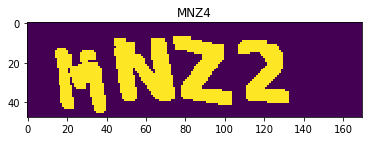

In [149]:
id = 15087//4
aa =""
for s in range(4):
    aa += codeTable[int(y1[id][s])]
plt.imshow(x1[id])
plt.title(aa)
plt.show()

Text(0.5,1,'4')

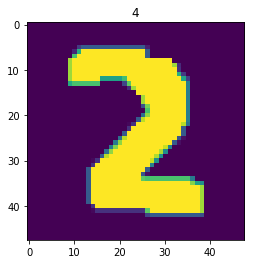

In [148]:
index = 15087
plt.imshow(x[index])
plt.title(codeTable[int(y[index])])

In [ ]:
'''

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.layers.convolutional import ZeroPadding2D
from keras import backend as K

from util import *
from scipy import io as scio
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import ssl
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
ssl._create_default_https_context = ssl._create_unverified_context

################################
# path = "third_single.mat"
# data = scio.loadmat(path)
# x = data['x_train']
# y = data['y_train']
# size = int((x.shape[0]-1)*0.8)#3736
# x = x[size:]
# y = y[size:]
# x_test = x.copy()
# y_test = y.copy()
################################
path = "third_single.mat"
data = scio.loadmat(path)
x = data['x_train']
y = data['y_train']
x_test = x.copy()
y_test = y.copy()



batch_size = 32
num_classes = 19
epochs = 10

# input image dimensions
img_rows, img_cols = 48, 48

##x_test、y_test
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0] , img_rows , img_cols , 1 , order="A")
y_test = keras.utils.to_categorical(y_test, num_classes)
print('in')

#------------------------------------------------
# ''' load last data'''
model = load_model('vgg_test4_with_third_data_1.h5')

## 评估模型
loss,accuracy = model.evaluate(x_test,y_test)
print('\nlast test loss',loss)
print('last ccuracy\n',accuracy)
#################################################
y_ = model.predict(x_test)

'''

In [ ]:
'''
load vgg_test4 再用third_single train
'''

os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
ssl._create_default_https_context = ssl._create_unverified_context

num_classes = 19
epochs = 10

# input image dimensions
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols,1)



################################
# path = "third_single.mat"
# data = scio.loadmat(path)
# x = data['x_train']
# y = data['y_train']
# size = int((x.shape[0]-1)*0.8)#3736
# x = x[size:]
# y = y[size:]
# x_test = x.copy()
# y_test = y.copy()
################################


x = x_test.copy()
y = y_test.copy()


##x_test、y_test
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0] , img_rows , img_cols , 1 , order="A")
y_test = keras.utils.to_categorical(y_test, num_classes)

print('in')

#------------------------------------------------
# ''' load last data'''
model = load_model('vgg_test4_with_third_data_1.h5')

## 评估模型
loss,accuracy = model.evaluate(x_test,y_test)
print('\nlast test loss',loss)
print('last ccuracy\n',accuracy)
#################################################
y_ = model.predict(x_test)

In [42]:

path = "train.mat" 
data = sio.loadmat(path)

x_test = data['x_train']
y_test = data['y_train']
###############################
eighty = int((x_test.shape[0]-1)*0.8)
x_test = data['x_train'][eighty:]
y_test = data['y_train'][eighty:]
###############################

input_size = x_test[0]

print("-----original-----")
print("x shape : ",x_test.shape)
print("y shape : ",y_test.shape)

codeTable = {0:'2',1:'3',2:'4',3:'5',4:'7',5:'9',
             6:'A',7:'C',8:'F',9:'H',10:'K',11:'M',12:'N',
             13:'P',14:'Q',15:'R',16:'T',17:'Y',18:'Z'}

x = []
y = []

size = x_test.shape[0]
index = 3
img = k_means(x_test[index])
# plt.plot(x, y, color='red')
# plt.imshow(x_test[index])


-----original-----
x shape :  (1169, 48, 170)
y shape :  (1169, 4)
center 51
limit 15
center 107
limit 12
center 26
limit 12
center 82
limit 14


In [13]:
img[0].shape

(48, 48)

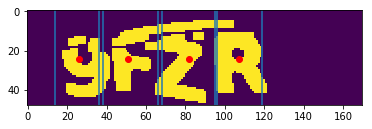

In [70]:
index = 415
plt.figure(0)
plt.imshow(x_test[index])
plt.plot(26, 24,'ro')
plt.axvline(x=14)
plt.axvline(x=38)
plt.plot(51, 24,'ro')
plt.axvline(x=66)
plt.axvline(x=36)
plt.plot(82, 24,'ro')
plt.axvline(x=68)
plt.axvline(x=96)
plt.plot(107, 24,'ro')
plt.axvline(x=95)
plt.axvline(x=119)
# plt.plot([5,10],[6,20])
plt.show()

In [80]:
from __future__ import print_function
import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.activations import relu

from util import *
from keras.layers.convolutional import ZeroPadding2D
from keras import backend as K
from scipy import io as spio
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import ssl
import os
from numpy import argmax
from sklearn.cluster import KMeans
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
ssl._create_default_https_context = ssl._create_unverified_context



In [83]:
data = spio.loadmat('third_single.mat')
x = data['x_train']
y = data['y_train']

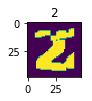

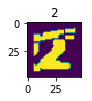

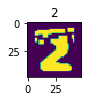

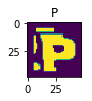

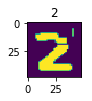

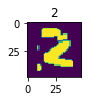

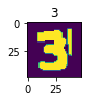

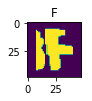

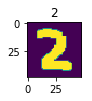

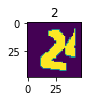

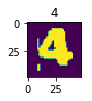

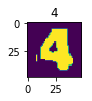

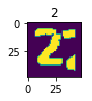

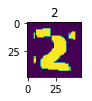

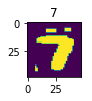

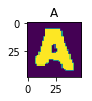

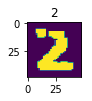

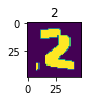

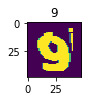

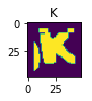

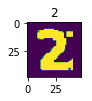

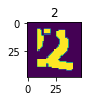

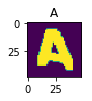

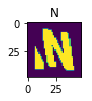

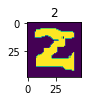

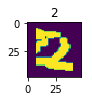

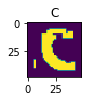

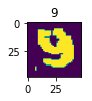

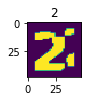

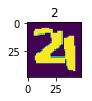

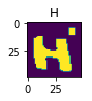

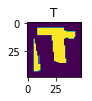

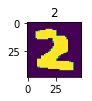

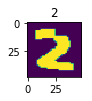

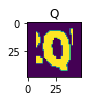

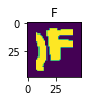

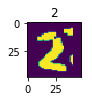

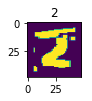

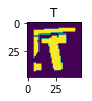

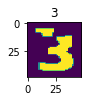

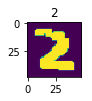

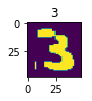

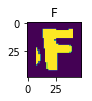

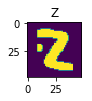

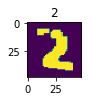

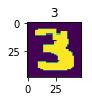

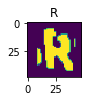

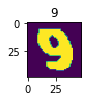

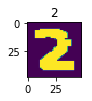

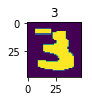

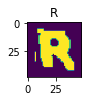

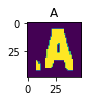

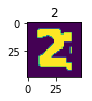

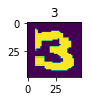

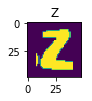

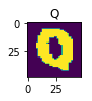

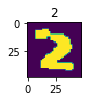

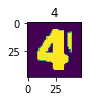

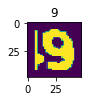

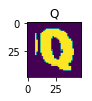

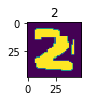

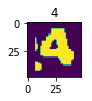

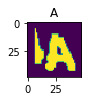

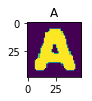

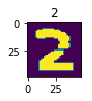

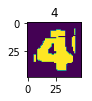

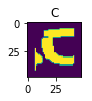

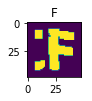

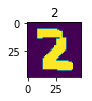

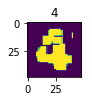

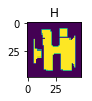

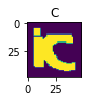

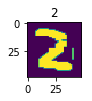

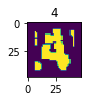

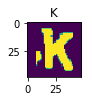

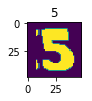

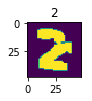

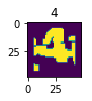

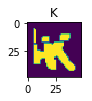

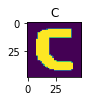

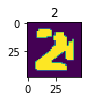

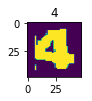

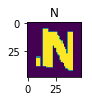

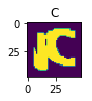

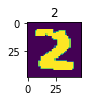

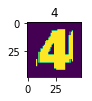

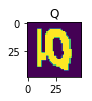

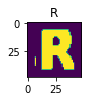

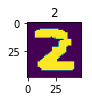

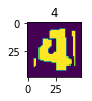

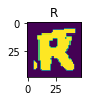

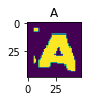

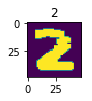

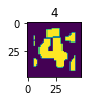

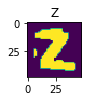

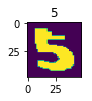

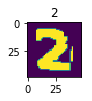

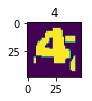

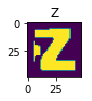

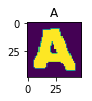

In [84]:
show_dataset(x,y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()